# Preparation
## Import necessary libraries

In [2]:
# Python libraries
import datetime as dt
import re
import pickle
from tqdm.notebook import tqdm
import os
import sys
from collections import defaultdict
from collections import Counter

# Data Science modules
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
plt.style.use('ggplot')

# Import Scikit-learn moduels
from sklearn.feature_extraction.text import CountVectorizer

# Import nltk modules and download dataset
import nltk
from nltk.corpus import stopwords
from nltk.util import ngrams
from nltk.tokenize import word_tokenize

nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

stop = set(stopwords.words('english'))

[nltk_data] Downloading package stopwords to /Users/yuki/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/yuki/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/yuki/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


## Load preprocessed data

In [14]:
# Load train data
file = open('../data/preprocessed/train_data.pickle', 'rb')
train_data = pickle.load(file)
file.close()

print(train_data.shape)
train_data.head()

(398, 33)


,unscheduled,forecast,confcall,ChairPerson,Rate,RateDecision,Lower,Hold,Raise,GDP_date,...,Unemp_diff_prev,Unemp_diff_year,Employ_date,Employ_value,Employ_diff_prev,Employ_diff_year,PMI_date,PMI_value,PMI_diff_prev,PMI_diff_year
date,,,,,,,,,,,,,,,,,,,,,
1982-10-05,False,False,False,Paul Volcker,9.5,-1.0,1,0,0,1982-04-01,...,0.3,2.5,1982-09-01,89183.0,-180.0,-2294.0,1982-09-01,38.8,0.5,-3.7
1982-11-16,False,False,False,Paul Volcker,9.0,-1.0,1,0,0,1982-07-01,...,0.3,2.5,1982-10-01,88907.0,-276.0,-2473.0,1982-10-01,39.4,0.6,-0.6
1982-12-21,False,False,False,Paul Volcker,8.5,0.0,0,1,0,1982-07-01,...,0.4,2.5,1982-11-01,88786.0,-121.0,-2385.0,1982-11-01,39.2,-0.2,3.1
1983-01-14,False,False,True,Paul Volcker,8.5,0.0,0,1,0,1982-07-01,...,0.0,2.3,1982-12-01,88771.0,-15.0,-2124.0,1982-12-01,42.8,3.6,5.0
1983-01-21,False,False,True,Paul Volcker,8.5,0.0,0,1,0,1982-07-01,...,0.0,2.3,1982-12-01,88771.0,-15.0,-2124.0,1982-12-01,42.8,3.6,5.0


In [7]:
# Load text data
file = open('../data/preprocessed/text_no_split.pickle', 'rb')
text_no_split = pickle.load(file)
file.close()

print(text_no_split.shape)
text_no_split

(7247, 9)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,"In taking the discount action, the Board appro..."
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,"In taking the discount rate action, the Board ..."
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,121,1,5.5,1994-12-20,"In a related move, the Federal Open Market Com..."
6,statement,1995-02-01,FOMC Statement,Alan Greenspan,54,1,6,1995-03-10,"In taking the discount action, the Board appro..."
7,statement,1995-07-06,FOMC Statement,Alan Greenspan,67,-1,5.75,1995-08-22,Chairman Alan Greenspan announced today that t...
8,statement,1995-12-19,FOMC Statement,Alan Greenspan,81,-1,5.5,1996-01-31,Chairman Alan Greenspan announced today that t...
9,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,For immediate releaseThe Federal Reserve today...


In [8]:
# Load text data
file = open('../data/preprocessed/text_split_200.pickle', 'rb')
text_split_200 = pickle.load(file)
file.close()

print(text_split_200.shape)
text_split_200

(77958, 9)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text
0,statement,1994-02-04,FOMC Statement,Alan Greenspan,99,1,3.25,1994-02-28,Chairman Alan Greenspan announced today that t...
1,statement,1994-03-22,FOMC Statement,Alan Greenspan,40,1,3.5,1994-04-18,Chairman Alan Greenspan announced today that t...
2,statement,1994-04-18,FOMC Statement,Alan Greenspan,37,1,3.75,1994-05-17,Chairman Alan Greenspan announced today that t...
3,statement,1994-05-17,FOMC Statement,Alan Greenspan,57,1,4.25,1994-07-06,In taking the discount action the Board approv...
4,statement,1994-08-16,FOMC Statement,Alan Greenspan,51,1,4.75,1994-09-27,In taking the discount rate action the Board a...
5,statement,1994-11-15,FOMC Statement,Alan Greenspan,121,1,5.5,1994-12-20,In a related move the Federal Open Market Comm...
6,statement,1995-02-01,FOMC Statement,Alan Greenspan,54,1,6,1995-03-10,In taking the discount action the Board approv...
7,statement,1995-07-06,FOMC Statement,Alan Greenspan,67,-1,5.75,1995-08-22,Chairman Alan Greenspan announced today that t...
8,statement,1995-12-19,FOMC Statement,Alan Greenspan,81,-1,5.5,1996-01-31,Chairman Alan Greenspan announced today that t...
9,statement,1996-01-31,FOMC Statement,Alan Greenspan,200,-1,5.25,1996-03-26,For immediate releaseThe Federal Reserve today...


In [9]:
# Load text data
file = open('../data/preprocessed/text_keyword.pickle', 'rb')
text_keyword = pickle.load(file)
file.close()

print(text_keyword.shape)
text_keyword

(4846, 9)


,type,date,title,speaker,word_count,decision,rate,next_meeting,text
0,statement,1994-05-17,FOMC Statement,Alan Greenspan,38,1,4.25,1994-07-06,The Board approved an increase in the discount...
1,statement,1994-11-15,FOMC Statement,Alan Greenspan,27,1,5.5,1994-12-20,"In a related move, the Federal Open Market Com..."
2,statement,1996-01-31,FOMC Statement,Alan Greenspan,391,-1,5.25,1996-03-26,For immediate releaseThe Federal Reserve today...
3,statement,1997-03-25,FOMC Statement,Alan Greenspan,405,1,5.5,1997-05-20,For immediate release\tThe Federal Open Market...
4,statement,1998-09-29,FOMC Statement,Alan Greenspan,373,-1,5.25,1998-10-15,For immediate releaseThe Federal Open Market C...
5,statement,1999-06-30,FOMC Statement,Alan Greenspan,477,1,5,1999-08-24,For immediate release\tThe Federal Open Market...
6,statement,1999-08-24,FOMC Statement,Alan Greenspan,927,1,5.25,1999-10-05,For immediate releaseThe Federal Open Market C...
7,statement,1999-11-16,FOMC Statement,Alan Greenspan,1280,1,5.5,1999-12-21,For immediate release\tThe Federal Open Market...
8,statement,2000-11-15,FOMC Statement,Alan Greenspan,876,0,6.5,2000-12-19,For immediate releaseThe Federal Open Market C...
9,statement,2001-01-31,FOMC Statement,Alan Greenspan,1345,-1,5.5,2001-03-20,For immediate releaseThe Federal Open Market C...


# EDA on train data set

In [16]:
train_data.describe()

,Rate,RateDecision,Lower,Hold,Raise,GDP_value,GDP_diff_prev,GDP_diff_year,GDPPOT_value,GDPPOT_diff_prev,...,CPI_diff_year,Unemp_value,Unemp_diff_prev,Unemp_diff_year,Employ_value,Employ_diff_prev,Employ_diff_year,PMI_value,PMI_diff_prev,PMI_diff_year
count,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,...,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000,398.000000
mean,4.058731,-0.025126,0.180905,0.663317,0.155779,12547.336480,0.648955,2.607880,12744.986274,0.653081,...,2.509759,6.148492,0.003015,-0.049749,122608.763819,117.902010,1479.469849,51.908291,0.095226,0.121106
std,3.080618,0.580430,0.385424,0.473170,0.363102,3571.171454,0.617932,1.938325,3593.469690,0.204383,...,1.158524,1.671659,0.173977,1.014622,16725.011183,227.914856,2006.202280,5.526310,1.918491,7.804065
min,0.000000,-1.000000,0.000000,0.000000,0.000000,6799.781000,-2.163811,-3.924447,7224.140335,0.263026,...,0.902110,3.500000,-0.700000,-2.900000,88771.000000,-1373.000000,-6823.000000,33.100000,-5.900000,-19.300000
25%,1.250000,0.000000,0.000000,0.000000,0.000000,9341.642000,0.430202,1.727214,9578.876710,0.483979,...,1.646593,4.900000,-0.100000,-0.600000,108532.750000,18.250000,486.750000,49.000000,-1.000000,-5.200000
50%,4.250000,0.000000,0.000000,1.000000,0.000000,12580.539500,0.638760,2.743811,12399.497235,0.646608,...,2.095070,5.800000,0.000000,-0.300000,129735.000000,173.500000,2137.000000,52.400000,0.050000,0.050000
75%,6.000000,0.000000,0.000000,1.000000,0.000000,15666.958500,0.969934,3.908121,16038.290220,0.819204,...,3.426380,7.100000,0.100000,0.300000,135052.250000,251.000000,2737.750000,55.800000,1.100000,4.500000
max,11.500000,1.000000,1.000000,1.000000,1.000000,19221.970000,2.275605,8.578274,19099.880000,1.064642,...,6.369058,10.800000,0.900000,4.000000,152463.000000,1118.000000,4903.000000,69.900000,8.400000,27.100000


In [18]:
train_data.isnull().sum()

unscheduled         0
forecast            0
confcall            0
ChairPerson         0
Rate                0
RateDecision        0
Lower               0
Hold                0
Raise               0
GDP_date            0
GDP_value           0
GDP_diff_prev       0
GDP_diff_year       0
GDPPOT_date         0
GDPPOT_value        0
GDPPOT_diff_prev    0
GDPPOT_diff_year    0
CPI_date            0
CPI_value           0
CPI_diff_prev       0
CPI_diff_year       0
Unemp_date          0
Unemp_value         0
Unemp_diff_prev     0
Unemp_diff_year     0
Employ_date         0
Employ_value        0
Employ_diff_prev    0
Employ_diff_year    0
PMI_date            0
PMI_value           0
PMI_diff_prev       0
PMI_diff_year       0
dtype: int64

Count: 
 0.0    264
-1.0     72
 1.0     62
Name: RateDecision, dtype: int64
Percent: 
 0.0    66.0
-1.0    18.0
 1.0    16.0
Name: RateDecision, dtype: float64


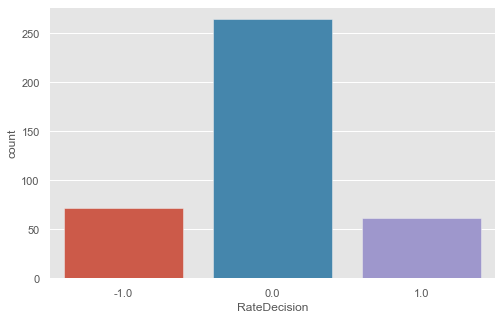

In [15]:
# The number of data per Target Labels
x = train_data['RateDecision'].value_counts()
print("Count: ")
print(x)
print("Percent: ")
print(round(x/sum(x) * 100))
# sns.barplot(x.index, x)
# plt.gca().set_ylabel('number of samples')
plt.figure(figsize=(8,5))
ax = sns.countplot(x='RateDecision', data=train_data)

The label is highly biased to 0(Hold). Need to consider how to mitigate the biased data.

In [0]:
# Corpus
def create_corpus(target):
    corpus = []
    
    for x in df[df['target']==target]['text'].str.split():
        for i in x:
            corpus.append(i)
    return corpus

# Returns Top X frequent words
def get_frequent_words(corpus, top_n=10):
    dic = defaultdict(int)
    for word in corpus:
        if word in stop:
            dic[word] += 1

    top = sorted(dic.items(), key=lambda x: x[1], reverse=True)[:top_n]

    return zip(*top)

In [ ]:
def tokenize_df(df):
    '''
    Extract words which are only aphabet and not in stop word, covert to lower case.
    '''
    tokenized = []
    wnl = nltk.stem.WordNetLemmatizer()
    for text in tqdm(df['text']):
        words = [word.lower() for word in word_tokenize(text) if ((word.isalpha()==1) & (word not in stop))]
        tokens = [wnl.lemmatize(wnl.lemmatize(word, 'n'), 'v') for word in words]
        tokenized.append(tokens)
    return tokenized

In [ ]:
from collections import Counter

print('len(tokenized): ', len(tokenized))
all_words = [word for text in tokenized for word in text]
#all_words = [word for word in text for text in tokenized]
#print(all_words[:20])
print('len(all_words): ', len(all_words))
counts = Counter(all_words)
print('len(counts): ', len(counts))
print('counts: ', counts)
bow = sorted(counts, key=counts.get, reverse=True)
print('bow[:20]', bow[:20])

In [ ]:
# Indexing vocabrary, starting from 1.
vocab = {word: ii for ii, word in enumerate(counts, 1)}
id2vocab = {v: k for k, v in vocab.items()}

print('vocab: ', vocab)

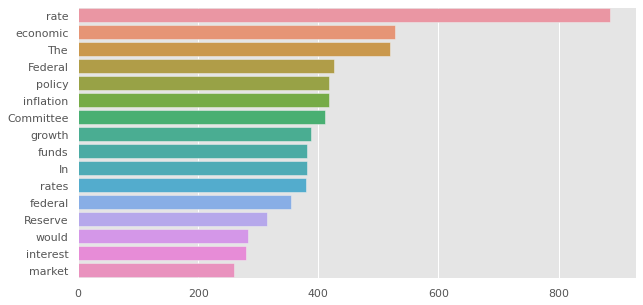

In [15]:
# Check most frequent words which are not in stopwords
counter = Counter(corpus_lower)
most = counter.most_common()
x, y = [], []
for word, count in most[:40]:
    if word not in stop:
        x.append(word)
        y.append(count)

plt.figure(figsize=(10,5))
sns.barplot(x=y, y=x)

Text(0.5, 1.0, 'Raise')

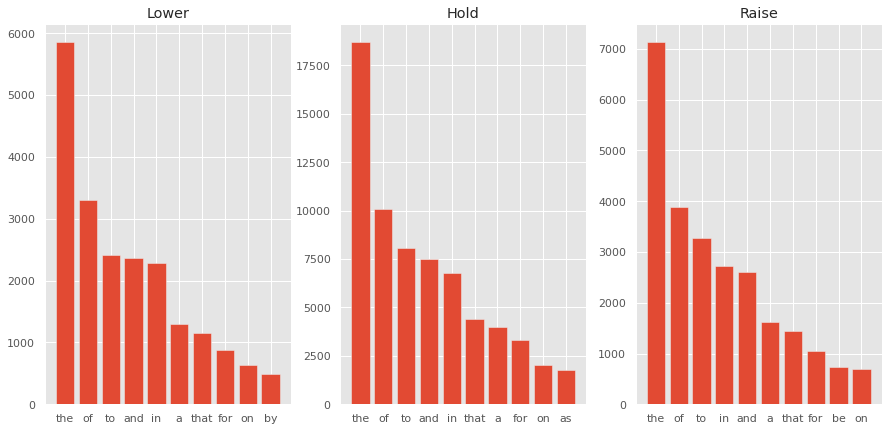

In [14]:
# Most frequent words
corpus_lower = create_corpus(0)
corpus_hold = create_corpus(1)
corpus_raise = create_corpus(2)

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,7))
x, y = get_frequent_words(corpus_lower)
ax1.bar(x, y)
ax1.set_title('Lower')
x, y = get_frequent_words(corpus_hold)
ax2.bar(x, y)
ax2.set_title('Hold')
x, y = get_frequent_words(corpus_raise)
ax3.bar(x, y)
ax3.set_title('Raise')

Text(0.5, 1.0, 'Speech')

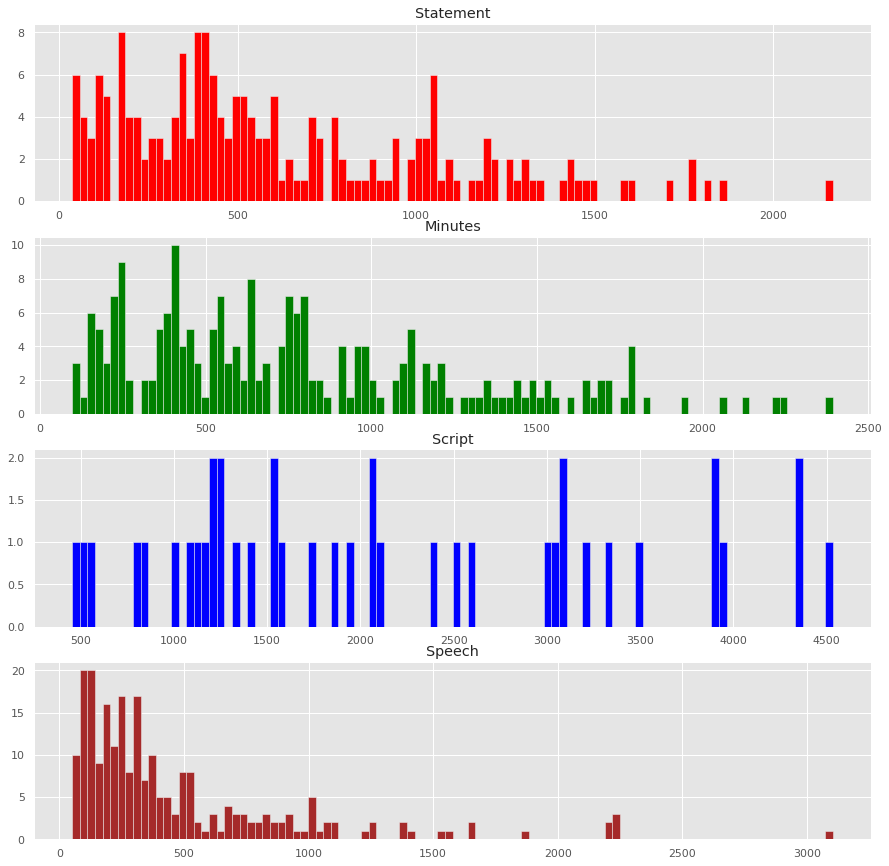

In [16]:
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(15,15))
# fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(15,15))
contents_len = df[df['type'] == 'statement']['word_count']
ax1.hist(contents_len, color='red', bins=100)
ax1.set_title('Statement')
contents_len = df[df['type'] == 'minutes']['word_count']
ax2.hist(contents_len, color='green', bins=100)
ax2.set_title('Minutes')
contents_len = df[df['type'] =='script']['word_count']
ax3.hist(contents_len, color='blue', bins=100)
ax3.set_title('Script')
contents_len = df[df['type'] =='speech']['word_count']
ax4.hist(contents_len, color='brown', bins=100)
ax4.set_title('Speech')


In [17]:
len(df[df['word_count'] > 300])

475

## Balancing classes

In [ ]:
n_hold = sum(1 for each in train_df['target'] if each == 1)
n_lower = sum(1 for each in train_df['target'] if each == 0)
n_raise = sum(1 for each in train_df['target'] if each == 2)
N_examples = len(train_df)

print('Hold: ', n_hold/N_examples)
print('Lower:', n_lower/N_examples)
print('Raise:', n_raise/N_examples)

In [ ]:
# Too many Hold. Better to randomly pick to even the distribution
n_hold = sum(1 for each in train_df['target'] if each == 1)
N_examples = len(train_df)
balanced = {'texts': [], 'targets': []}

# Keep probability
keep_prob = (N_examples - n_hold)/2/n_hold
#keep_prob = 1

for idx, target in enumerate(train_df['target']):
    text = tokenized[idx]
    if len(text) == 0:
        continue
    elif target != 1 or random.random() < keep_prob:
        balanced['texts'].append(text)
        balanced['targets'].append(target)

n_hold = sum(1 for each in balanced['targets'] if each == 1)
n_lower = sum(1 for each in balanced['targets'] if each == 0)
n_raise = sum(1 for each in balanced['targets'] if each == 2)
N_examples = len(balanced['targets'])
print('Hold: ', n_hold/N_examples)
print('Lower:', n_lower/N_examples)
print('Raise:', n_raise/N_examples)